In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_ccf
from statsmodels.tsa.stattools import ccf
from scipy.stats import uniform, randint

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

# Do XGBoost with autoregressive vars

In [71]:
df = pd.read_csv('./data/daily.csv')
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [72]:
def create_date_features(df):
    df = df.copy()
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['week'] = df.index.isocalendar().week
    df['dayofyear'] = df.index.dayofyear
    return df

def clean_nas(df):
    df = df.copy()
    df.ffill(inplace=True)
    df.dropna(inplace=True)
    return df

In [73]:
df = create_date_features(df)
df = clean_nas(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12584 entries, 1990-01-01 to 2024-06-14
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TAVG_flag       12584 non-null  object 
 1   TAVG_origFlag   12584 non-null  object 
 2   TAVG_origValue  12584 non-null  float64
 3   TAVG_value      12584 non-null  float64
 4   WTEQ_average    12584 non-null  float64
 5   WTEQ_flag       12584 non-null  object 
 6   WTEQ_origFlag   12584 non-null  object 
 7   WTEQ_origValue  12584 non-null  float64
 8   WTEQ_value      12584 non-null  float64
 9   agency_cd       12584 non-null  object 
 10  site_no         12584 non-null  int64  
 11  CFS             12584 non-null  int64  
 12  status          12584 non-null  object 
 13  year            12584 non-null  int32  
 14  quarter         12584 non-null  int32  
 15  month           12584 non-null  int32  
 16  week            12584 non-null  UInt32 
 17  dayofyear     

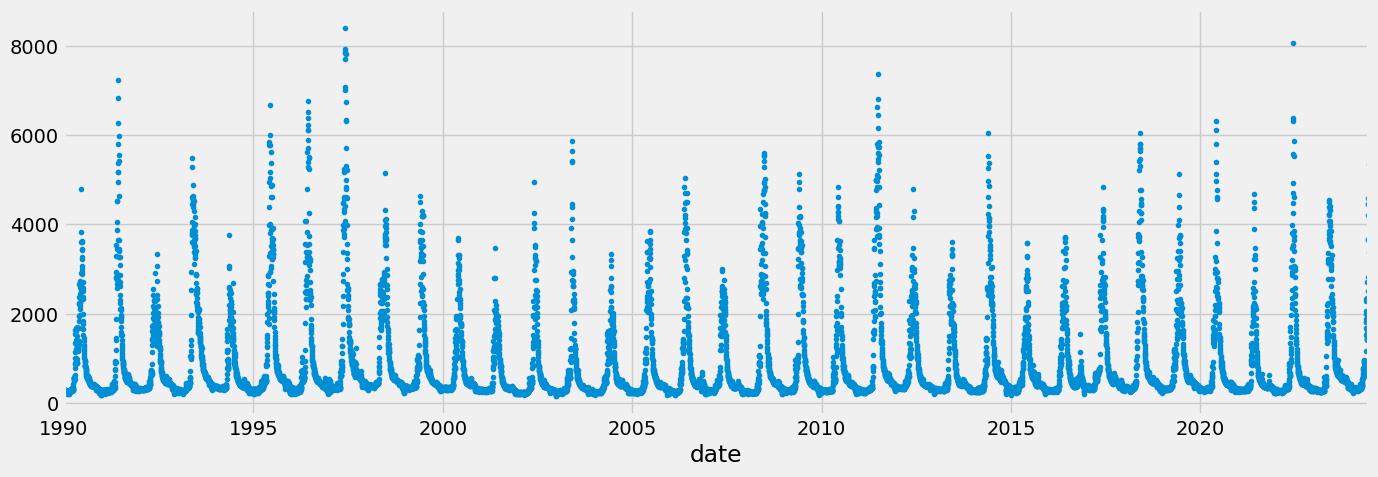

In [74]:
df['CFS'].plot(style='.', figsize=(15, 5), color=color_pal[0])
plt.show()

<Axes: ylabel='Frequency'>

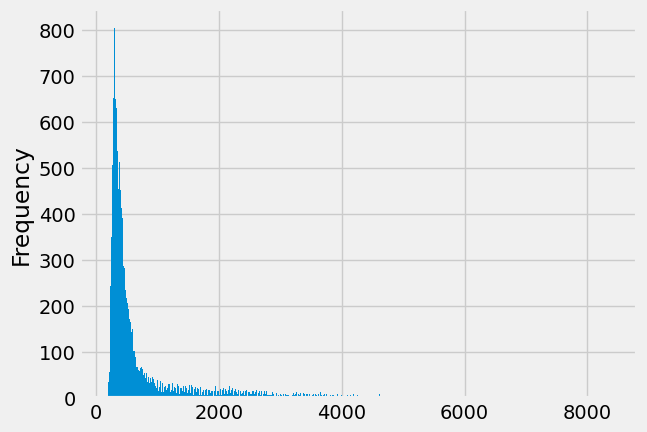

In [75]:
df["CFS"].plot(kind='hist', bins=500)

<Axes: ylabel='Frequency'>

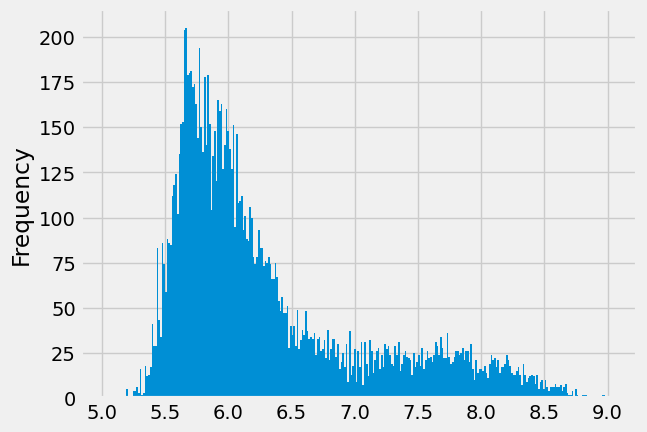

In [76]:
np.log(df["CFS"]).plot(kind='hist', bins=300)

# Exploration and TS Analysis

In [77]:
TARGET = 'CFS'
FEATURES = ['TAVG_origValue', 'WTEQ_average', 'WTEQ_origValue',
            'year', 'quarter', 'month', 'dayofyear']
df = df[[*FEATURES, TARGET]]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12584 entries, 1990-01-01 to 2024-06-14
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TAVG_origValue  12584 non-null  float64
 1   WTEQ_average    12584 non-null  float64
 2   WTEQ_origValue  12584 non-null  float64
 3   year            12584 non-null  int32  
 4   quarter         12584 non-null  int32  
 5   month           12584 non-null  int32  
 6   dayofyear       12584 non-null  int32  
 7   CFS             12584 non-null  int64  
dtypes: float64(3), int32(4), int64(1)
memory usage: 688.2 KB


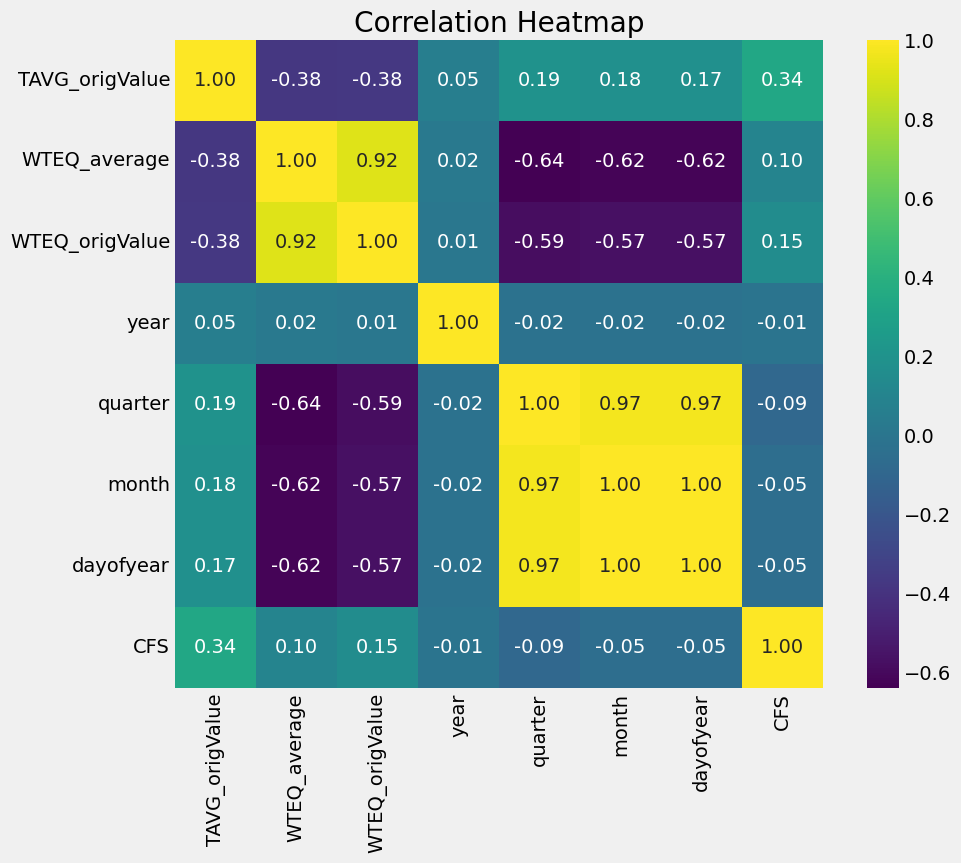

In [78]:
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis', square=True)
plt.title('Correlation Heatmap')
plt.show()

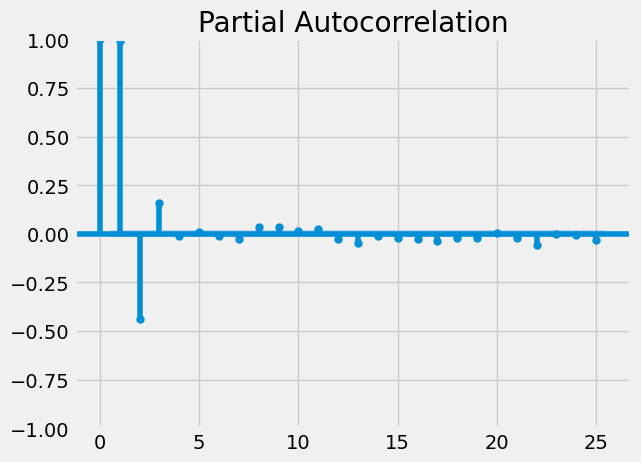

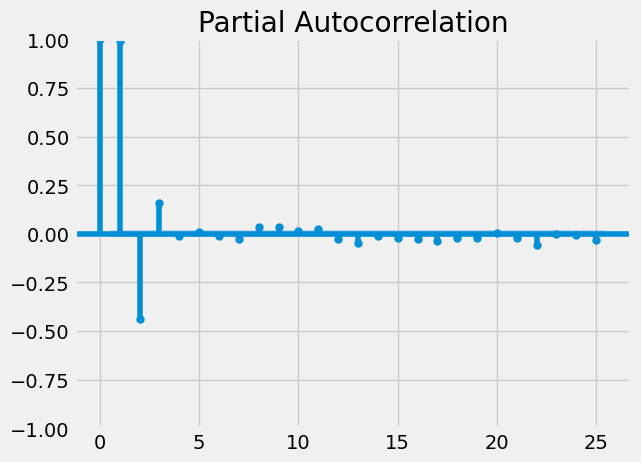

In [79]:
plot_pacf(df['CFS'], lags=25)
# go find your r script looking at this because these plots suck (exploratory_with_snotel.R)

# Train test split for CV

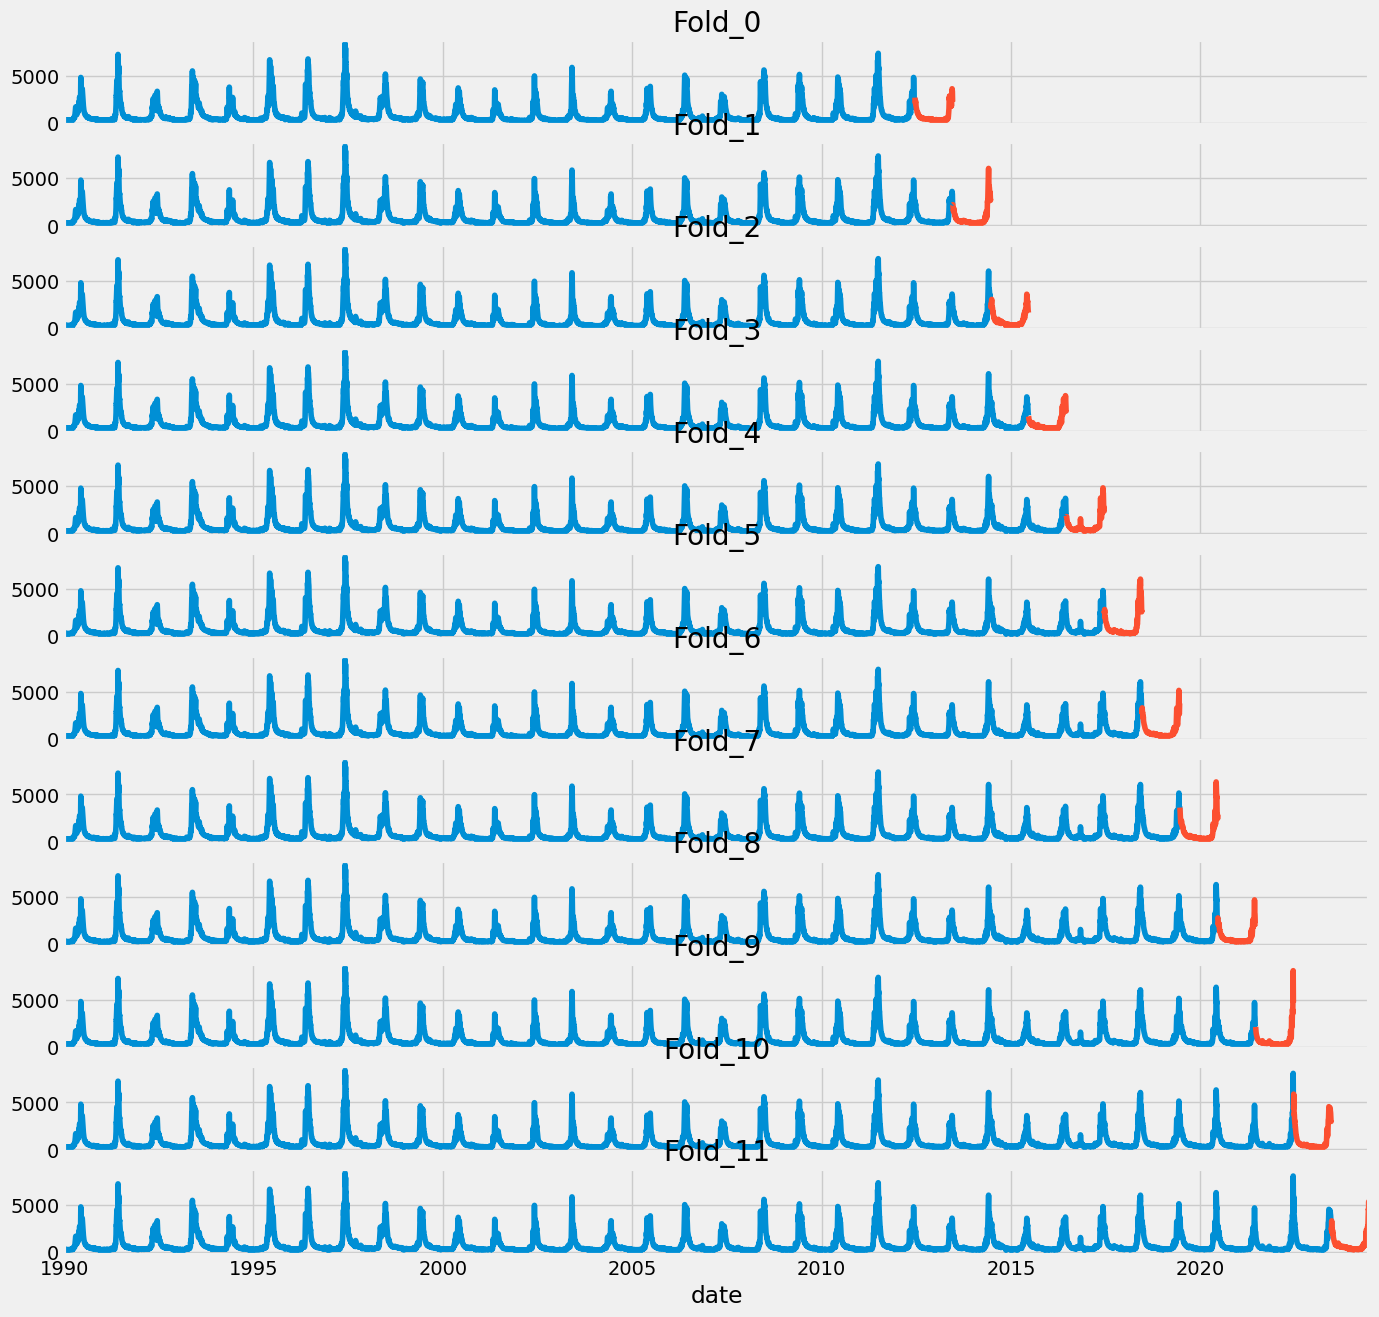

In [80]:
splits = 12
tss = TimeSeriesSplit(n_splits=splits, test_size=365, gap=0)
df = df.sort_index()
fig, axs = plt.subplots(splits, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train["CFS"].plot(ax=axs[fold], label="TRAIN", title=f"Fold_{fold}")
    test["CFS"].plot(ax=axs[fold], label="TEST")
    fold += 1
plt.show()

## Make features

In [81]:
def add_cfs_lags(df):
    target_map = df['CFS'].to_dict()
    df['CFS_lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['CFS_lag365'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    return df

def add_temp_lags(df):
    target_map = df['TAVG_origValue'].to_dict()
    df['TAVG_lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['TAVG_lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['TAVG_lag3'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['TAVG_lag365'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    return df

def add_first_difference(df, column_name='WTEQ_origValue'):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame")

    diff_column_name = f'{column_name}_diff'
    df[diff_column_name] = df[column_name].diff()

    return df

In [82]:
df = add_cfs_lags(df)
df = add_temp_lags(df)
df = add_first_difference(df)

In [83]:
df.head()

,TAVG_origValue,WTEQ_average,WTEQ_origValue,year,quarter,month,dayofyear,CFS,CFS_lag1,CFS_lag365,TAVG_lag1,TAVG_lag2,TAVG_lag3,TAVG_lag365,WTEQ_origValue_diff
date,,,,,,,,,,,,,,,
1990-01-01,19.2,9.9,11.4,1990,1,1,1,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-02,10.9,10.0,11.8,1990,1,1,2,290,275.0,NaN,19.2,NaN,NaN,NaN,0.4
1990-01-03,3.9,10.1,11.8,1990,1,1,3,258,290.0,NaN,10.9,19.2,NaN,NaN,0.0
1990-01-04,11.5,10.2,12.0,1990,1,1,4,249,258.0,NaN,3.9,10.9,19.2,NaN,0.2
1990-01-05,14.5,10.3,12.0,1990,1,1,5,269,249.0,NaN,11.5,3.9,10.9,NaN,0.0


# Run XGB with cv

In [84]:
splits = 12
tss = TimeSeriesSplit(n_splits=splits, test_size=365, gap=0)
df = df.sort_index()

fold = 0
preds = []
scores = []
mapes = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    TARGET = 'CFS'
    FEATURES = ['TAVG_origValue', 'WTEQ_average', 'WTEQ_origValue',
                'CFS_lag1', 'CFS_lag365', 'TAVG_lag1', 'TAVG_lag2',
                'TAVG_lag365', 'WTEQ_origValue_diff',
                'year', 'quarter', 'month', 'dayofyear']

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                          n_estimators=1000, early_stopping_rounds=50,
                          objective='reg:squarederror', max_depth=3, learning_rate=.01)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    scores.append(score)
    mapes.append(mape)
    fold += 1
    print(f'#### Finished fold {fold} of {splits} ####')

[0]	validation_0-rmse:1300.16207	validation_1-rmse:996.07685
[100]	validation_0-rmse:504.73956	validation_1-rmse:371.94283
[200]	validation_0-rmse:229.44644	validation_1-rmse:147.83820
[300]	validation_0-rmse:143.97353	validation_1-rmse:87.54686
[400]	validation_0-rmse:118.04795	validation_1-rmse:78.02142
[468]	validation_0-rmse:110.26031	validation_1-rmse:77.99244
#### Finished fold 1 of 12 ####
[0]	validation_0-rmse:1288.67034	validation_1-rmse:1280.46477
[100]	validation_0-rmse:500.00698	validation_1-rmse:483.30044
[200]	validation_0-rmse:227.41217	validation_1-rmse:197.14065
[300]	validation_0-rmse:142.14179	validation_1-rmse:114.06564
[400]	validation_0-rmse:116.30470	validation_1-rmse:105.29732
[454]	validation_0-rmse:109.87003	validation_1-rmse:110.22996
#### Finished fold 2 of 12 ####
[0]	validation_0-rmse:1288.33853	validation_1-rmse:1092.51234
[100]	validation_0-rmse:499.73073	validation_1-rmse:405.92760
[200]	validation_0-rmse:227.23233	validation_1-rmse:158.25986
[300]	vali

In [43]:
print(f'RMSE Avg across folds {np.mean(scores):0.4f}')
print(f'MAPE Avg across foles {np.mean(mapes):0.4f}')
print(f'\n Scores: {scores}')
print(f'\n MAPES: {(mapes)}')

RMSE Avg across folds 99.0404
MAPE Avg across foles 0.0444

 Scores: [np.float64(77.60231697954096), np.float64(105.26928392580248), np.float64(74.22673227268676), np.float64(68.39260804734131), np.float64(87.76993648378388), np.float64(113.72838507066817), np.float64(83.79087998368728), np.float64(118.63712157432718), np.float64(78.80395620912225), np.float64(171.48113704115366), np.float64(103.06818667921432), np.float64(105.7148442171829)]

 MAPES: [np.float64(0.03955424203547716), np.float64(0.04092873558783275), np.float64(0.05114952265716475), np.float64(0.04241681482847037), np.float64(0.04824790330566086), np.float64(0.04669950309010338), np.float64(0.0426453255428036), np.float64(0.048114608731419165), np.float64(0.041642505521069094), np.float64(0.04858866110437382), np.float64(0.03754563365344492), np.float64(0.04508559124865554)]


## Hyperparameter tuning:

In [49]:
splits = 12
tss = TimeSeriesSplit(n_splits=splits, test_size=365, gap=0)
df = df.sort_index()

fold = 0
preds = []
scores = []
mapes = []
best_params = []

param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5)
}

TARGET = 'CFS'
FEATURES = ['TAVG_origValue', 'WTEQ_average', 'WTEQ_origValue',
            'CFS_lag1', 'CFS_lag365', 'TAVG_lag1', 'TAVG_lag2',
            'TAVG_lag365', 'WTEQ_origValue_diff',
            'quarter', 'month', 'dayofyear']

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    X_train = train[FEATURES]
    y_train = np.log(train[TARGET])

    X_test = test[FEATURES]
    y_test = np.log(test[TARGET])

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', base_score=0.5, booster='gbtree')

    # Set up RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=50,
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test)
    preds.append(y_pred)

    # Calculate metrics
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    scores.append(score)
    mapes.append(mape)
    best_params.append(random_search.best_params_)

    fold += 1
    print(f'#### Finished fold {fold} of {splits} ####')
    print(f'Best parameters: {random_search.best_params_}')
    print(f'RMSE: {score}')
    print(f'MAPE: {mape}')
    print('-------------------')

# Print overall results
print(f'Average RMSE: {np.mean(scores)}')
print(f'Average MAPE: {np.mean(mapes)}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
#### Finished fold 1 of 12 ####
Best parameters: {'colsample_bytree': np.float64(0.9720067339243328), 'gamma': np.float64(0.03520806542477195), 'learning_rate': np.float64(0.07267561528460804), 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 738, 'subsample': np.float64(0.8073318609454947)}
RMSE: 0.053382144762273175
MAPE: 0.006403955577846169
-------------------
Fitting 3 folds for each of 50 candidates, totalling 150 fits
#### Finished fold 2 of 12 ####
Best parameters: {'colsample_bytree': np.float64(0.9720067339243328), 'gamma': np.float64(0.03520806542477195), 'learning_rate': np.float64(0.07267561528460804), 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 738, 'subsample': np.float64(0.8073318609454947)}
RMSE: 0.0499257382972679
MAPE: 0.005734363319440963
-------------------
Fitting 3 folds for each of 50 candidates, totalling 150 fits
#### Finished fold 3 of 12 ####
Best parameters: {'colsample_bytree': 

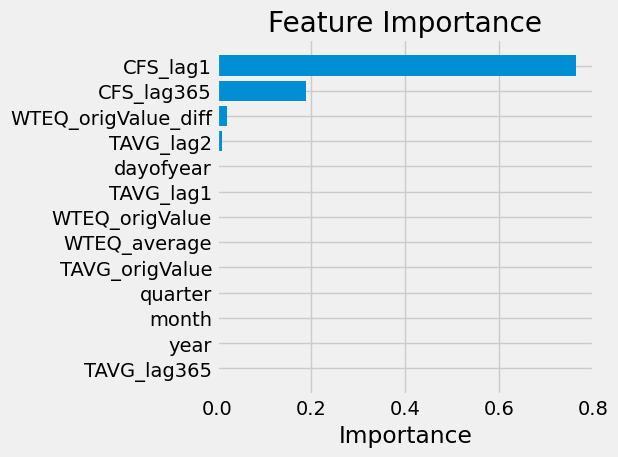

In [50]:
importance = best_model.feature_importances_
sorted_idx = importance.argsort()
plt.barh(range(len(sorted_idx)), importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [FEATURES[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

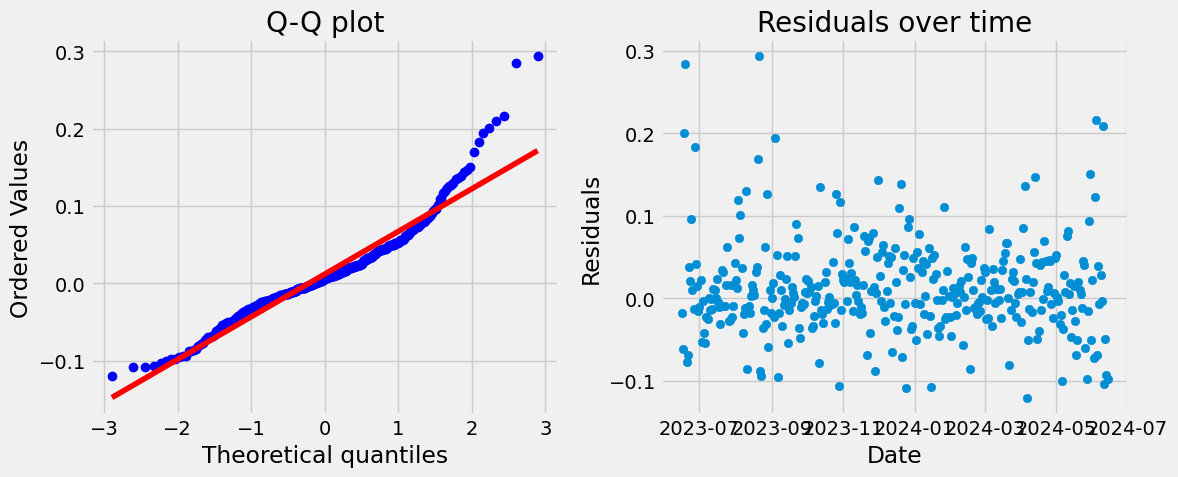

In [51]:
import scipy.stats as stats

residuals = y_test - y_pred
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

stats.probplot(residuals, dist="norm", plot=ax1)
ax1.set_title("Q-Q plot")

ax2.scatter(test.index, residuals)
ax2.set_title("Residuals over time")
ax2.set_xlabel("Date")
ax2.set_ylabel("Residuals")

plt.tight_layout()
plt.show()

# Next: Hybrid model (xgb + prophet)